In [44]:
import cv2 as cv
import pyfeats
import glob
import os
import re
import numpy as np
from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
img_filenames = sorted(glob.glob('/home/alvin/Documents/Masters/CV/dataset/*/*.jpg'), key=lambda f: os.path.split(f)[-1])
msk_filenames = sorted(glob.glob('/home/alvin/Documents/Masters/CV/masks/*.jpg'), key=lambda f: os.path.split(f)[-1])

assert len(img_filenames) == len(msk_filenames)

labels = [re.split('/', os.path.split(img)[0])[-1] for img in img_filenames]

In [3]:
def load_img_features(filenames):

  img_file, msk_file = filenames

  img = cv.imread(img_file, cv.IMREAD_GRAYSCALE)
  mask = cv.imread(msk_file, cv.IMREAD_GRAYSCALE)

  # compute first order statistics/statistical features
  fos_features, _ = pyfeats.fos(img, mask)

  # compute local binary pattern features
  lbp_features, _ = pyfeats.lbp_features(img, mask, P=[8,16,24], R=[1,2,3])

  # compute histogram based features
  hist_features, _ = pyfeats.multiregion_histogram(img, mask, bins=32, num_eros=3, square_size=3)

  # compute Hu's moments
  moments_features, _ = pyfeats.hu_moments(img)

  return [fos_features.reshape(-1, 1), lbp_features.reshape(-1, 1), hist_features.reshape(-1, 1), moments_features.reshape(-1, 1)]

In [4]:
img_features = list(map(load_img_features, zip(img_filenames, msk_filenames)))

In [5]:
features_arr = np.asarray([np.vstack(feature) for feature in img_features]).squeeze()

In [6]:
encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)
classes = encoder.classes_

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features_arr, labels_enc, test_size=0.2, random_state=42)

In [8]:
scaler =  StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import

In [10]:
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=3)

In [11]:
gnb.fit(X_train, y_train)

GaussianNB()

In [12]:
knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.metrics import classification_report_imbalanced

def cm(y_true, y_pred, labels=None):
  '''
  Generates and displays a confusion matrix
  '''
  matrix = confusion_matrix(y_true, y_pred)

  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion Matrix")
  cm_display.plot(ax=plt.subplot(), colorbar=False)
  plt.show()

(641, 6)

In [38]:
pred_gnb = gnb.predict_proba(X_test)
y_pred_gnb = gnb.predict(X_test)
roc_auc_score(pd.get_dummies(y_test).values, pred_gnb, average='weighted', multi_class='ovr', labels=classes)

0.8998998068746762

In [39]:
pred_knc = knc.predict_proba(X_test)
y_pred_knc = knc.predict(X_test)
roc_auc_score(pd.get_dummies(y_test).values, pred_knc, average='weighted', multi_class='ovr', labels=classes)

0.9977935373709129

In [42]:
# Evaluate results
print(classification_report(pd.get_dummies(y_test).values, pd.get_dummies(y_pred_gnb).values, target_names=classes))
print(classification_report_imbalanced(y_test, y_pred_gnb, target_names=classes))

              precision    recall  f1-score   support

     bananas       0.61      0.82      0.70        56
     cassava       0.77      0.46      0.58       192
       grass       0.54      0.67      0.60        82
   jackfruit       0.89      0.98      0.93        43
       maize       0.72      0.90      0.80       225
   sugarcane       0.55      0.26      0.35        43

   micro avg       0.70      0.70      0.70       641
   macro avg       0.68      0.68      0.66       641
weighted avg       0.70      0.70      0.68       641
 samples avg       0.70      0.70      0.70       641

                   pre       rec       spe        f1       geo       iba       sup

    bananas       0.61      0.82      0.95      0.70      0.88      0.77        56
    cassava       0.77      0.46      0.94      0.58      0.66      0.41       192
      grass       0.54      0.67      0.92      0.60      0.78      0.60        82
  jackfruit       0.89      0.98      0.99      0.93      0.98      0.

In [43]:
# Evaluate results
print(classification_report(pd.get_dummies(y_test).values, pd.get_dummies(y_pred_knc).values, target_names=classes))
print(classification_report_imbalanced(y_test, y_pred_knc, target_names=classes))

              precision    recall  f1-score   support

     bananas       0.98      0.96      0.97        56
     cassava       0.98      0.99      0.99       192
       grass       1.00      1.00      1.00        82
   jackfruit       1.00      1.00      1.00        43
       maize       0.99      1.00      0.99       225
   sugarcane       0.98      0.93      0.95        43

   micro avg       0.99      0.99      0.99       641
   macro avg       0.99      0.98      0.98       641
weighted avg       0.99      0.99      0.99       641
 samples avg       0.99      0.99      0.99       641

                   pre       rec       spe        f1       geo       iba       sup

    bananas       0.98      0.96      1.00      0.97      0.98      0.96        56
    cassava       0.98      0.99      0.99      0.99      0.99      0.98       192
      grass       1.00      1.00      1.00      1.00      1.00      1.00        82
  jackfruit       1.00      1.00      1.00      1.00      1.00      1.

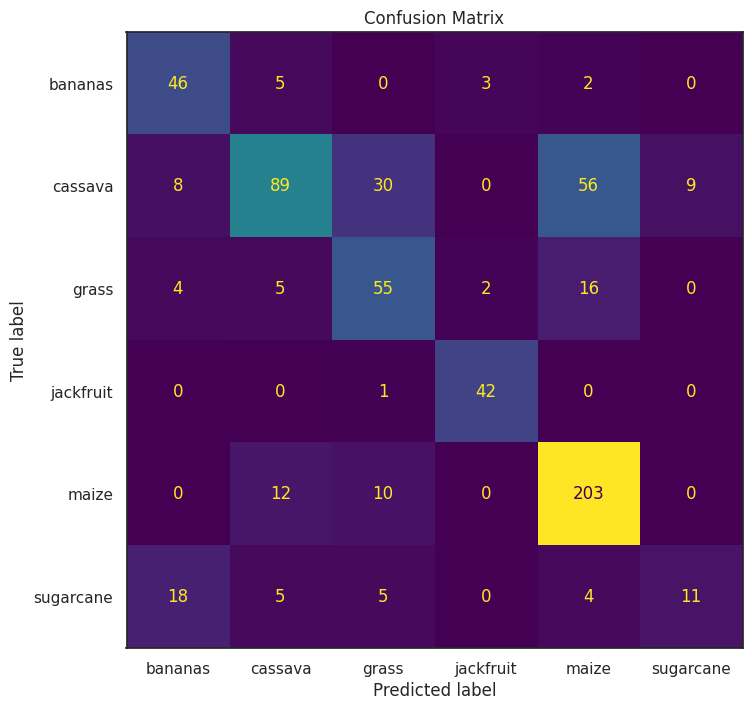

In [46]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
cm(np.argmax(pd.get_dummies(y_test).values, axis=-1), y_pred_gnb, labels=classes)

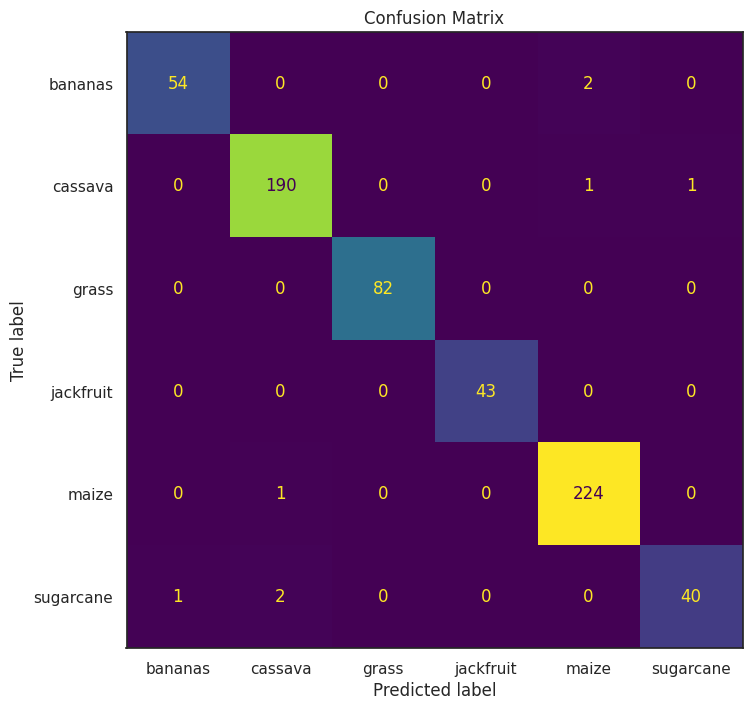

In [47]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
cm(np.argmax(pd.get_dummies(y_test).values, axis=-1), y_pred_knc, labels=classes)